In [1]:
from pathlib import Path
from fastai import *
from fastai.tabular import *

In [2]:
# path to permission datasets

clean_data = 'permissions_csv/AV-vendor/clean/permissions.csv'
adware_data = 'permissions_csv/AV-vendor/adware/permissions.csv'
model_path = 'Model/'

In [4]:
# sanity check, if this failed training data is missing

assert Path(clean_data).is_file()
assert Path(adware_data).is_file()

In [3]:
# read data into pandas dataframes

clean_df = pd.read_csv(clean_data)
adware_df = pd.read_csv(adware_data)

In [4]:
# see how many possible permissions we have in total

all_permissions = list(clean_df.columns)
len(all_permissions)

904

In [5]:
# see how many training examples we have in total (first nr of each tuple)

clean_df.shape, adware_df.shape

((29142, 904), (29759, 904))

In [6]:
# get rid of duplicates (different versions of app with unchanged features) and see how many remain

clean_df.drop_duplicates(subset=all_permissions, inplace=True)
clean_df.shape

(14902, 904)

In [7]:
# get rid of duplicates (different versions of app with unchanged features) and see how many remain

adware_df.drop_duplicates(subset=all_permissions, inplace=True)
adware_df.shape

(11860, 904)

In [9]:
n_clean = clean_df.shape[0]  # nr of rows
n_adware = adware_df.shape[0]  # nr of rows

In [10]:
# creating the labels:
clean_df['label'] = [0] * n_clean
adware_df['label'] = [1] * n_adware

In [11]:
# merging the different labeled datasets (clean/adware) into a single dataset to draw from

df = clean_df.append(adware_df, ignore_index=True)
df

,.permission.READ_SETTINGS,.permission.RECEIVE_FIRST_LOAD_BROADCAST,.permission.RECEIVE_LAUNCH_BROADCASTS,.permission.WRITE_SETTINGS,MODIFY_PHONE_STATE,abhijith.carboncontacts.permission.C2D_MESSAGE,amirz.rootless.nexuslauncher.permission.READ_SETTINGS,amirz.rootless.nexuslauncher.permission.WRITE_SETTINGS,android.Manifest.permission.OVERRIDE_WIFI_CONFIG,android.hardware.camera.autofocus,...,taipei.sean.telegram.botplayground.permission.C2D_MESSAGE,thedorkknightrises.notes.permission.C2D_MESSAGE,thinkpanda.permission.CLEAR_MISSED_CALL,timeline.lizimumu.com.t.permission.C2D_MESSAGE,tr.xip.wanikani.permission.C2D_MESSAGE,whispeer.app.permission.C2D_MESSAGE,whispeer.app.permission.PushHandlerActivity,wordtextcounter.details.main.permission.C2D_MESSAGE,yuku.alkitab.kjv.permission.C2D_MESSAGE,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26757,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
26758,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
26759,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
26760,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [12]:
# randomizing order of data

np.random.seed(42) # IMPORTANT for repeatable split train/validation datasets
shuffled_df = df.sample(frac=1).reset_index(drop=True) # drop=True to prevent pandas from creating a new row with mixed up index
# shuffled_df = shuffled_df.iloc[:15000] # only use subset since laptop has limited RAM

In [29]:
shuffled_df

,.permission.READ_SETTINGS,.permission.RECEIVE_FIRST_LOAD_BROADCAST,.permission.RECEIVE_LAUNCH_BROADCASTS,.permission.WRITE_SETTINGS,MODIFY_PHONE_STATE,abhijith.carboncontacts.permission.C2D_MESSAGE,amirz.rootless.nexuslauncher.permission.READ_SETTINGS,amirz.rootless.nexuslauncher.permission.WRITE_SETTINGS,android.Manifest.permission.OVERRIDE_WIFI_CONFIG,android.hardware.camera.autofocus,...,taipei.sean.telegram.botplayground.permission.C2D_MESSAGE,thedorkknightrises.notes.permission.C2D_MESSAGE,thinkpanda.permission.CLEAR_MISSED_CALL,timeline.lizimumu.com.t.permission.C2D_MESSAGE,tr.xip.wanikani.permission.C2D_MESSAGE,whispeer.app.permission.C2D_MESSAGE,whispeer.app.permission.PushHandlerActivity,wordtextcounter.details.main.permission.C2D_MESSAGE,yuku.alkitab.kjv.permission.C2D_MESSAGE,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26757,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
26758,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26759,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26760,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [13]:
# dependent variable
dep_var = 'label'

# list of categorical data
cat_names = list(shuffled_df.columns)[:-1] # excluding 'label' at the end (since that is our dependent variable)
procs = [Categorify]  # preprocess (fastai categorifies categorical data)

In [14]:
# splitting dataset into test and validation set

validationset_size = int(shuffled_df.shape[0] * 0.2)
testset_size = shuffled_df.shape[0] - validationset_size
print('size of test set:', testset_size)
print('size of validation set:', validationset_size)
print('total size of dataset:', testset_size + validationset_size)

size of test set: 21410
size of validation set: 5352
total size of dataset: 26762


In [15]:
# creating test-set

test = TabularList.from_df(shuffled_df.iloc[0:testset_size].copy(), path=model_path, cat_names=cat_names)

In [16]:
# creating DataBunch for Model

data = (TabularList.from_df(shuffled_df, path=model_path, cat_names=cat_names, procs=procs)
       .split_by_idx(list(range(testset_size)))  # split into training/validation sets
       .label_from_df(cols=dep_var)
       .add_test(test, label=0) # TODO: figure out what label=0 does
       .databunch())

In [17]:
# creating actual model

learn = tabular_learner(data=data, layers=[200, 100], metrics=accuracy)

In [18]:
# train for 1 epoch to ensure everything runs

learn.fit(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.516765,0.504403,0.758851,00:59


In [19]:
# find optimal learning rate

learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


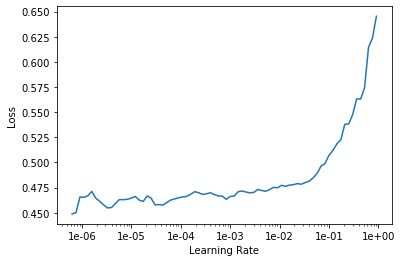

In [21]:
learn.recorder.plot()

In [22]:
# train for longer time with better learning rate

learn.fit(5, 3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.467418,0.486872,0.767492,00:58
1,0.456985,0.482679,0.771275,00:58
2,0.450774,0.488348,0.766744,00:54
3,0.440202,0.484558,0.770528,00:55
4,0.425921,0.484535,0.769407,00:58


In [24]:
learn.save('v0.1')

In [25]:
learn.fit(5, 7e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.413314,0.481157,0.772630,00:56
1,0.405887,0.484155,0.772303,00:56
2,0.403623,0.484403,0.771695,00:56
3,0.402892,0.484405,0.772069,00:56
4,0.400198,0.487447,0.769080,00:57


In [26]:
learn.save('v0.2')

In [27]:
learn.fit(5, 7e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.398859,0.486312,0.769267,00:59
1,0.388496,0.491012,0.770107,00:56
2,0.386976,0.488684,0.771415,00:56
3,0.387738,0.494425,0.765717,00:56
4,0.385187,0.491617,0.768473,00:59


In [28]:
learn.save('v0.3')

In [44]:
learn.fit(5, 3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.382574,0.527498,0.753526,00:58
1,0.375793,0.514865,0.764783,00:57
2,0.367025,0.525583,0.759645,00:56
3,0.363202,0.520480,0.767445,00:58
4,0.351291,0.534389,0.758617,00:57


In [45]:
learn.save('v0.4')

In [46]:
learn.fit(5, 4e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.349815,0.560532,0.737179,00:58
1,0.342392,0.576972,0.755908,00:58
2,0.335237,0.576341,0.730640,00:57
3,0.337733,0.569511,0.758010,00:58
4,0.327099,0.624333,0.724148,00:57


In [47]:
learn.fit(5, 5e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.320535,0.783694,0.674451,01:00
1,0.319863,0.638766,0.724988,00:57
2,0.307896,0.646274,0.737646,00:58
3,0.302541,0.656387,0.722980,00:59
4,0.295779,0.631914,0.715647,00:59


In [48]:
learn.fit(5, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.261346,0.570726,0.757543,01:01
1,0.256496,0.594392,0.747548,00:59
2,0.248570,0.590584,0.754134,00:59
3,0.246585,0.601944,0.752125,00:58
4,0.237037,0.601845,0.752732,00:58


In [49]:
learn.save('already_overfitted') # run for longer to find overfit-limit for sure

In [35]:
clean_df.iloc[0]

.permission.READ_SETTINGS                              0
.permission.RECEIVE_FIRST_LOAD_BROADCAST               0
.permission.RECEIVE_LAUNCH_BROADCASTS                  0
.permission.WRITE_SETTINGS                             0
MODIFY_PHONE_STATE                                     0
                                                      ..
whispeer.app.permission.C2D_MESSAGE                    0
whispeer.app.permission.PushHandlerActivity            0
wordtextcounter.details.main.permission.C2D_MESSAGE    0
yuku.alkitab.kjv.permission.C2D_MESSAGE                0
label                                                  0
Name: 0, Length: 905, dtype: int64

In [37]:
learn.predict(clean_df.iloc[0])

(Category 0, tensor(0), tensor([0.7277, 0.2723]))

In [38]:
learn.predict(adware_df.iloc[0])

(Category 1, tensor(1), tensor([0.3375, 0.6625]))

In [58]:
learn.predict??

In [42]:
pred = learn.predict(adware_df.iloc[10])
pred

(Category 1, tensor(1), tensor([0.4275, 0.5725]))

In [43]:
type(pred)

tuple

In [48]:
learn.predict(clean_df.iloc[-1])

(Category 0, tensor(0), tensor([0.9918, 0.0082]))

In [56]:
clean_df.iloc[-1].value_counts()

0    903
1      2
Name: 29140, dtype: int64

In [49]:
learn.predict(adware_df.iloc[-1])

(Category 0, tensor(0), tensor([0.6088, 0.3912]))

In [57]:
adware_df.iloc[-1].value_counts()

0    885
1     20
Name: 29758, dtype: int64